# exploration 4번째 과제</br>
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [1]:
import math
import warnings
import os
import sys
import numpy as np
import pandas as pd
from enum import Enum
from matplotlib import pyplot as plt
from pathlib import Path
from typing import Union

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## 상수선언

In [2]:
class P_ValueThresholdPercent(Enum):
    """
    사회과학과 자연과학간의 p-value 역치
    역치는 백분율이다.
    """
    social_science = 5 # 사회과학 데이터용
    natural_science = 1 # 자연과학 데이터용

TIME_COL = "Close"
THRESHOLD = P_ValueThresholdPercent.social_science.value / 100

# [file name]:[company name]
COM_DICT = {
    "KO.csv" : "caca cola"
    , "SBUX.csv" : "starbucks"
    , "NKE.csv" : "nike"
    , "AMZN.csv" : "amazon"
    , "ORCL.csv" : "oracle"
}

warnings.filterwarnings('ignore') #경고 무시

DATA_PATH = os.path.join(Path("./").parent.resolve().parent.resolve().parent.resolve(),"data")

## 함수선언

In [3]:
def plot_rolling_statistics(
    timeseries:pd.Series
    , window=12
) -> Union[pd.Series, None]:
    """
    시계열 데이터를 log정규화 후
    데이터에 대한 이동평균과 이동표준편차를 계산, 그래프 작성
    만약 NaN값이 존재할 경우 데이터를 선형보간한다.

    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터
    window : int, default = 12
        시게열 데이터의 반복주기
        기본값은 12로 1년데이터를 기준으로 한다.

    Returns
    ----------
    timeseries : Series
        - 보간이 된 시계열 데이터

    """
    timeseries = np.log(timeseries)

    # 결측치 보간
    if timeseries.isna().any():
        timeseries = timeseries.interpolate(method='time')
    
    rolling = timeseries.rolling(window=window)  # 구간통계

    # 시각화
    orig = plt.plot(timeseries, color='blue',label='Original') # 원본    
    mean = plt.plot(rolling.mean(), color='red', label='Rolling Mean') # 이동평균
    std = plt.plot(rolling.std(), color='black', label='Rolling Std') # 이동표준편차
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    return timeseries

시계열 데이터를 `NaN`값은 선형보간에 의해 값을 보간한다.</br>
그 후, 원본, 이동평균, 이동표준편차를 확인하기 위한 그래프를 그린다.

In [4]:
def plot_seasonal_decompose(timeseries:pd.Series) -> None:
    """
    시계열 데이터를 
     - 추세
     - 계절성
     - 원본 - 추세 - 계절성
    로 분해해 그래프로 표시
    그 중 residual요소만 리턴

    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터

    Returns
    ----------
    residual : Series
        
    """

    decomposition = seasonal_decompose(timeseries, model='multiplicative', period = 30) 

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본 - 추세 - 계절성


    plt.figure(figsize=(10,6))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    return residual

시계열 분해 (Time Series Decomposition) 후 각각 트렌트, 계절성, 그 이외의 성질을 그래프로 나타냄

In [5]:
def augmented_dickey_fuller_test(
    timeseries:pd.Series
    , p_value_threshold:P_ValueThresholdPercent=P_ValueThresholdPercent.social_science
    ) -> bool:
    """
    아래의 상황에서 경고를 출력
     - p-value가 역치이하

    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터
    p_value_threshold : P_ValueThresholdPercent, default = P_ValueThresholdPercent.social_science
        p-value의 역치값을 설정
        기본은 사회과학 데이터 기준이다.
        설정관련 사항은 아래와 같다.
        - 사회과학 분야의 데이터 경우 : social_science(5%)
        - 자연과학 분야의 데이터 경우 : natural_science(1%)

    Returns
    ----------
    is_stationary : bool
        안정적 시계열 여부
    """
    is_stationary = True

    # 시계열 데이터 검증값 계산
    adfuller_value = adfuller(timeseries, autolag='AIC')

    critical_value = adfuller_value[4]
    adfuller_value = adfuller_value[:4]
    
    adfuller_value = {
        col:v 
        for v, col in 
        zip(
            adfuller_value, ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
        )
    }

    adfuller_value.update({
        f"Critical Value ({k})":v 
        for k, v in 
        critical_value.items()
    })

    # 다음의 상황을 시계열이 연속적이지 않다고 가정한다.
    # - p-value가 역치를 넘을 경우
    if adfuller_value["p-value"] > p_value_threshold.value / 100:
        print("stationary한 시계열 데이터가 아닙니다.")
        is_stationary = False
        

    for k,v in adfuller_value.items():
        print(f"{k} : {v}")

    return is_stationary

시계열 데이터가 다음의 조건일 경우 경고메세지 출력.
 - p-value가 역치이상

In [6]:
def acf(timeseries:pd.Series, k:int) -> float:
    """
    `ARIMA`의 `q`값을 구하기위한 함수
    
    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터
    k : int
        구하고자 하는 lag

    Returns
    ----------
    acf_val : float
        k차의 lag
    """
    data = np.array(timeseries).reshape(-1)
    mean = data.mean()
 
    numerator = np.sum((data[:len(data)-k] - mean) * (data[k:] - mean))
    denominator = np.sum(np.square(data - mean))
 
    acf_val = numerator / denominator
 
    return acf_val

`ARIMA`의 `q`값을 구하기 위해 `acf`수식을 계산하는 함수이다.</br>
`k`차의 `lag`를 구한다.</br>

In [7]:
def pacf(timeseries:pd.Series, k:int) -> float:
    """
    `ARIMA`의 `p`값을 구하기위한 함수
    
    Parameters
    ----------
    timeseries : Series of datetime64
        시게열 데이터
    k : int
        구하고자 하는 lag

    Returns
    ----------
    pacf_val : float
        k차의 lag 
    """
    if k == 0:
        pacf_val = 1
    else:
        gamma_array = np.array([acf(timeseries, k) for k in range(1,k+1)])

        gamma_matrix = np.array([[0]*i + [acf(timeseries, j) for j in range(k-i)] for i in range(k)])
        gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())

        pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]

    return pacf_val

`ARIMA`의 `p`값을 구하기 위해 `acf`수식을 계산하는 함수이다.</br>
`k`차의 `lag`를 구한다.</br>

## 공통화(함수화)전에 플로 테스트

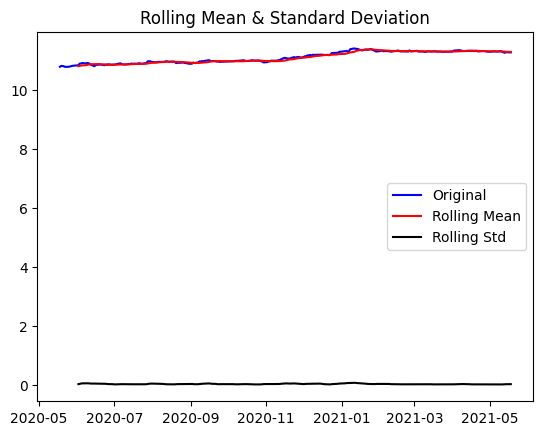

stationary한 시계열 데이터가 아닙니다.
Test Statistic : -1.3835246914203967
p-value : 0.5901486083403977
#Lags Used : 0
Number of Observations Used : 249
Critical Value (1%) : -3.4568881317725864
Critical Value (5%) : -2.8732185133016057
Critical Value (10%) : -2.5729936189738876


In [8]:
# 예시데이터
dataset_filepath = os.path.join(DATA_PATH, "005930.KS.csv")
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

close = df.pop(TIME_COL)
close = plot_rolling_statistics(close)

augmented_dickey_fuller_test(close)

df = pd.concat([df, close], axis=1)
cols = df.columns.to_list()
cols.remove(TIME_COL)
df = df[cols].interpolate(method="values")

해당 과정을 시행한다.
 - `Nan`값에 대한 선형보간
 - 원본, 이동평균, 이동표준편차를 확인하기 위한 그래프 작성

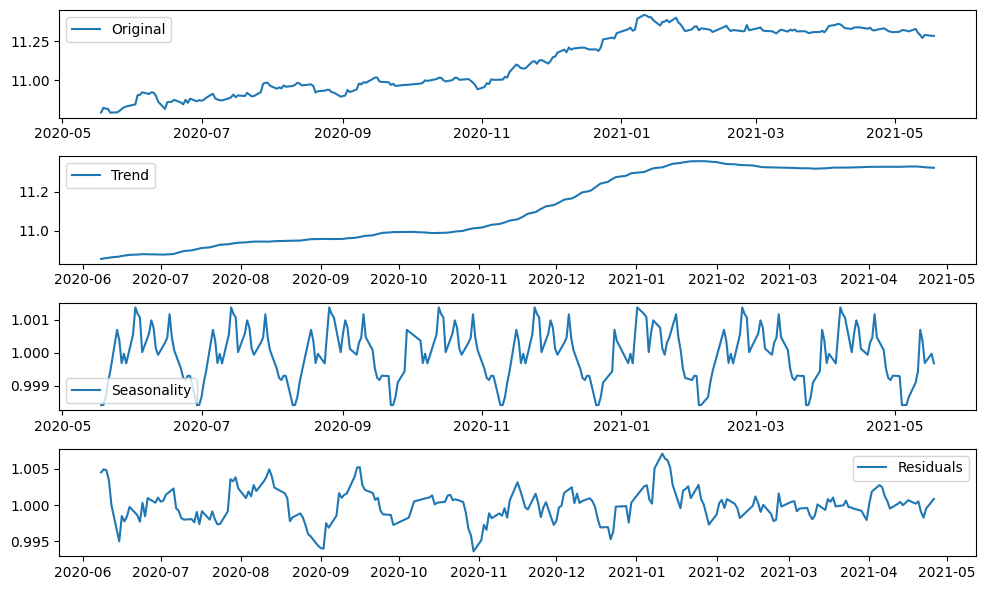

In [9]:
residual = plot_seasonal_decompose(close)
residual.dropna(inplace=True)

다음과 같은 동작을 수행한다.
- 시계열 분해 후, Residual 안정성 확인(분석 및 그래프 작성)
    - 정성적 그래프 분석
    - 정량적 그래프 분석
    - 원본(로그변환한) - 추세 - 계절성
- `Nan`값 필터링

In [10]:
augmented_dickey_fuller_test(residual)

Test Statistic : -6.1875855954225
p-value : 6.234854469399257e-08
#Lags Used : 9
Number of Observations Used : 210
Critical Value (1%) : -3.461878735881654
Critical Value (5%) : -2.875403665910809
Critical Value (10%) : -2.574159410430839


True

시계열 데이터가

 > stationary한 시계열 데이터가 아닙니다.

라는 메세지가 출력될 경우</br>
차분화가 필요함.

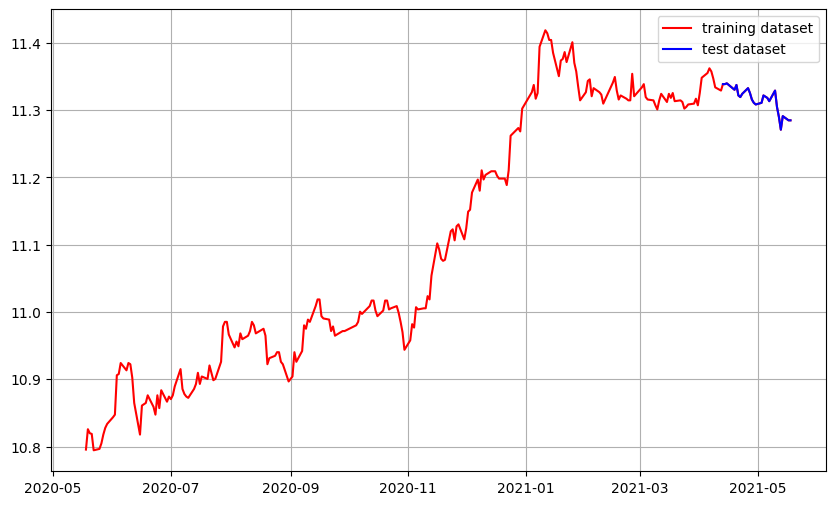

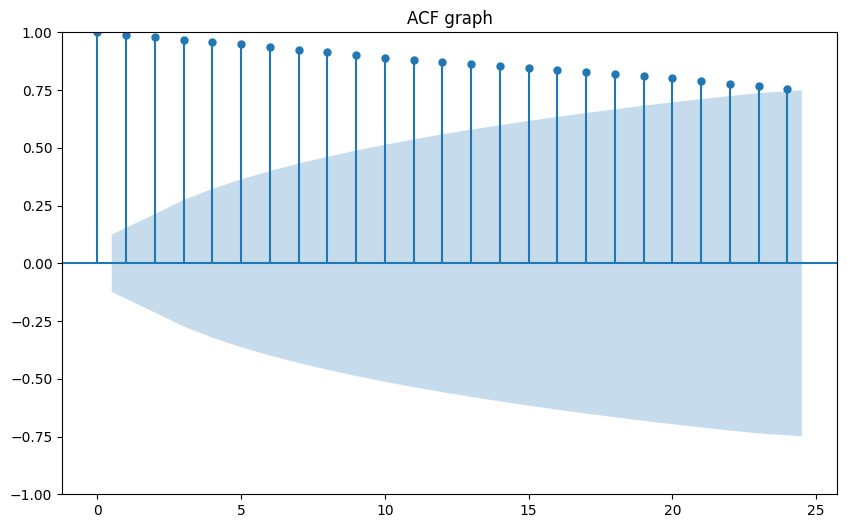

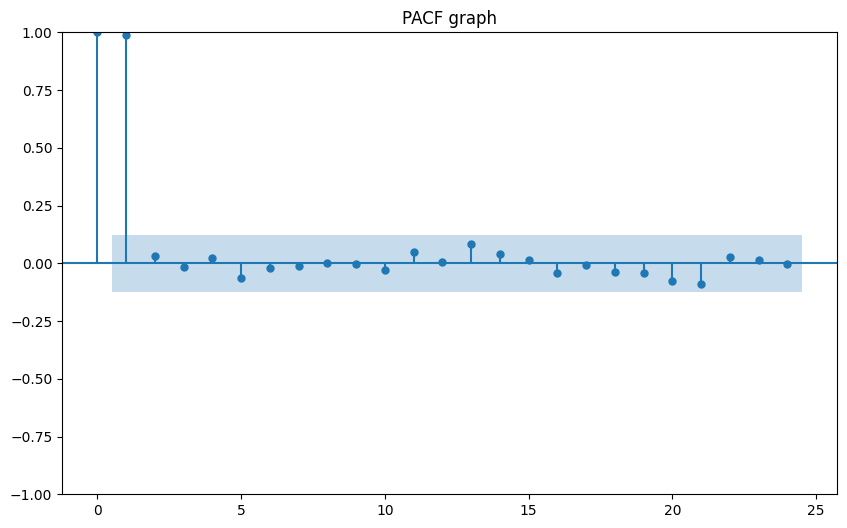

In [11]:
# train, test data 생성
train_data, test_data = close[:int(len(close)*0.9)], close[int(len(close)*0.9):]

# 예측된 주식가격 예측
plt.figure(figsize=(10,6)), 
plt.grid(True)
plt.plot(close, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

fig, ax1 = plt.subplots(figsize=(10,6))
fig, ax2 = plt.subplots(figsize=(10,6))
plot_acf(close, title='ACF graph', ax=ax1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(close, title='PACF graph', method="ywm", ax=ax2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


train data, test data를 9:1로 생성 후</br>
그래프를 그려 아래의 사실을 가능</br>
 - ACF그래프에서 하강이 완만한 경우 차분화 필요
 - PACF가 0으로 수렴하지 않는 경우 차분화 필요

`acf leg`와 `pacf lag`는 차수를 기준으로 구한다.


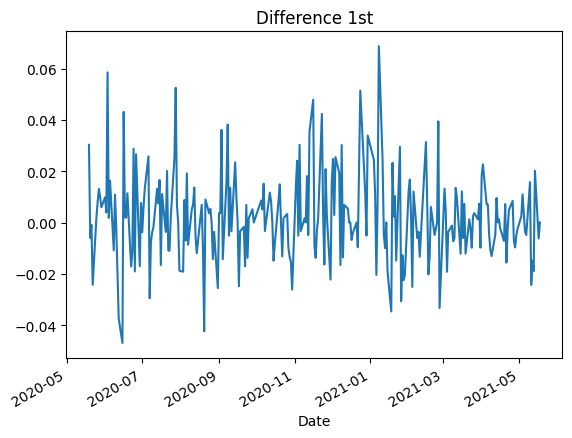

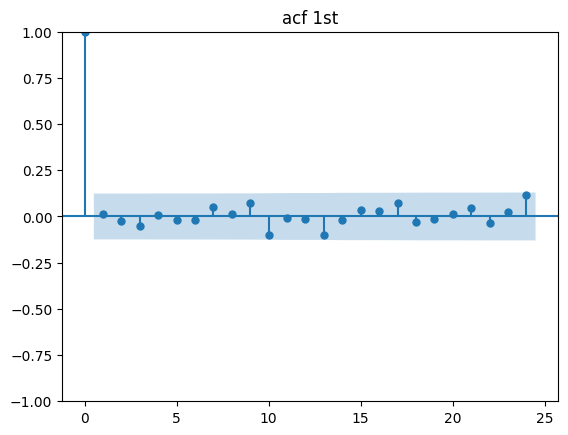

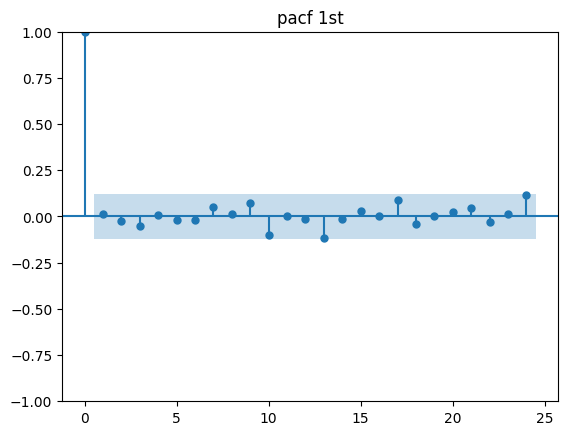

Test Statistic : -15.536987202555839
p-value : 2.1837375080919526e-28
#Lags Used : 0
Number of Observations Used : 248
Critical Value (1%) : -3.4569962781990573
Critical Value (5%) : -2.8732659015936024
Critical Value (10%) : -2.573018897632674


In [12]:

# p,차분,q 구하기
q_lag = -1
p_lag = -1
d = 0
diff = close[::]

while True:
    diff = diff.diff(periods=1).iloc[1:]

    diff.plot(title=f'Difference {d+1}st')
    plt.show()

    plot_acf(diff, title=f'acf {d+1}st')
    plt.show()

    plot_pacf(diff, title=f'pacf {d+1}st')
    plt.show()

    d += 1
    if augmented_dickey_fuller_test(diff):
        acf_list = [abs(acf(diff, k)) <= THRESHOLD for k in range(30)]
        q_lag = acf_list.index(True) - 1

        pacf_list = [abs(pacf(diff, k)) <= THRESHOLD for k in range(30)]
        p_lag = pacf_list.index(True)
        break

`차분한 횟수`를 `ARIMA`의 `d`로 설정

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Sat, 01 Oct 2022   AIC                          -1162.976
Time:                        18:44:26   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

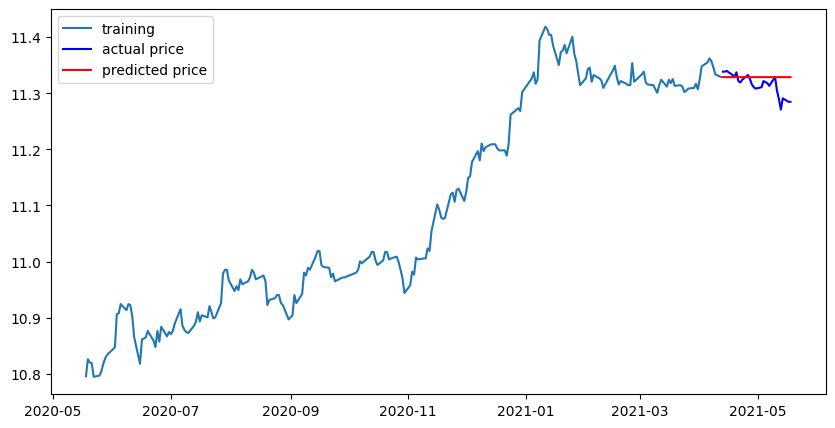

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


In [13]:
# p,d,q 순서대로 arima 모델 적용
model = ARIMA(train_data, order=(p_lag, d, q_lag))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=THRESHOLD)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

## 플로 공통화

In [14]:
def analysis(csv_name:str) -> float:
    """
    각 기업의 주식값을 분석하고
    `소수점 2자리까지의 MAPE`값을 리턴
    
    Parameters
    ----------
    csv_name : str
        분석할 csv이름

    Returns
    ----------
    pacf_val : float
        k차의 lag 
    """
    dataset_filepath = os.path.join(DATA_PATH, csv_name)
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

    close = df.pop(TIME_COL)
    close = plot_rolling_statistics(close)

    print("\nafter log trans")
    augmented_dickey_fuller_test(close)

    df = pd.concat([df, close], axis=1)
    cols = df.columns.to_list()
    cols.remove(TIME_COL)
    df = df[cols].interpolate(method="values")

    print("\nafter except seasonal, transe")
    residual = plot_seasonal_decompose(close)
    residual.dropna(inplace=True)

    augmented_dickey_fuller_test(residual)

    # train, test data 생성
    train_data, test_data = close[:int(len(close)*0.9)], close[int(len(close)*0.9):]

    # 예측된 주식가격 예측
    plt.figure(figsize=(10,6)), 
    plt.grid(True)
    plt.plot(close, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

    fig, ax1 = plt.subplots(figsize=(10,6))
    fig, ax2 = plt.subplots(figsize=(10,6))
    plot_acf(close, title='ACF graph', ax=ax1)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(close, title='PACF graph', method="ywm", ax=ax2)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

    # p,차분,q 구하기
    q_lag = -1
    p_lag = -1
    d = 0
    diff = close[::]

    while True:
        diff = diff.diff(periods=1).iloc[1:]

        diff.plot(title=f'Difference {d+1}st')
        plt.show()

        plot_acf(diff, title=f'acf {d+1}st')
        plt.show()

        plot_pacf(diff, title=f'pacf {d+1}st')
        plt.show()

        d += 1
        if augmented_dickey_fuller_test(diff):
            acf_list = [abs(acf(diff, k)) <= THRESHOLD for k in range(30)]
            q_lag = acf_list.index(True) - 1

            pacf_list = [abs(pacf(diff, k)) <= THRESHOLD for k in range(30)]
            p_lag = pacf_list.index(True)
            break

    # p,d,q 순서대로 arima 모델 적용
    model = ARIMA(train_data, order=(p_lag, d, q_lag))  
    fitted_m = model.fit() 

    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=THRESHOLD)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()

    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

    return round(mape*100, 2)

위의 플로부분을 공통화 시켰다.

## 분석


############# caca cola analysis #############



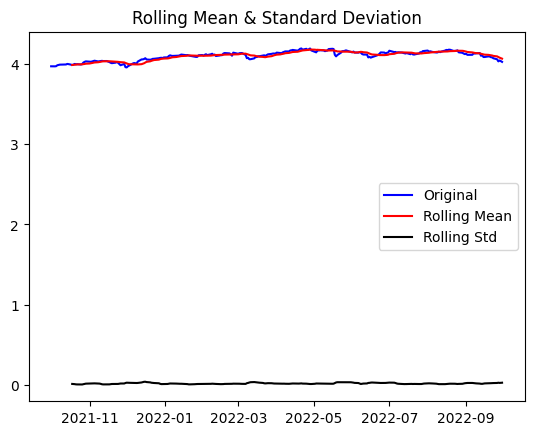


after log trans
stationary한 시계열 데이터가 아닙니다.
Test Statistic : -2.1998782218847324
p-value : 0.20628965825390894
#Lags Used : 0
Number of Observations Used : 251
Critical Value (1%) : -3.4566744514553016
Critical Value (5%) : -2.8731248767783426
Critical Value (10%) : -2.5729436702592023

after except seasonal, transe
Test Statistic : -5.59432757080205
p-value : 1.3074540524070702e-06
#Lags Used : 2
Number of Observations Used : 219
Critical Value (1%) : -3.460567372610299
Critical Value (5%) : -2.874829809033386
Critical Value (10%) : -2.573853225954421


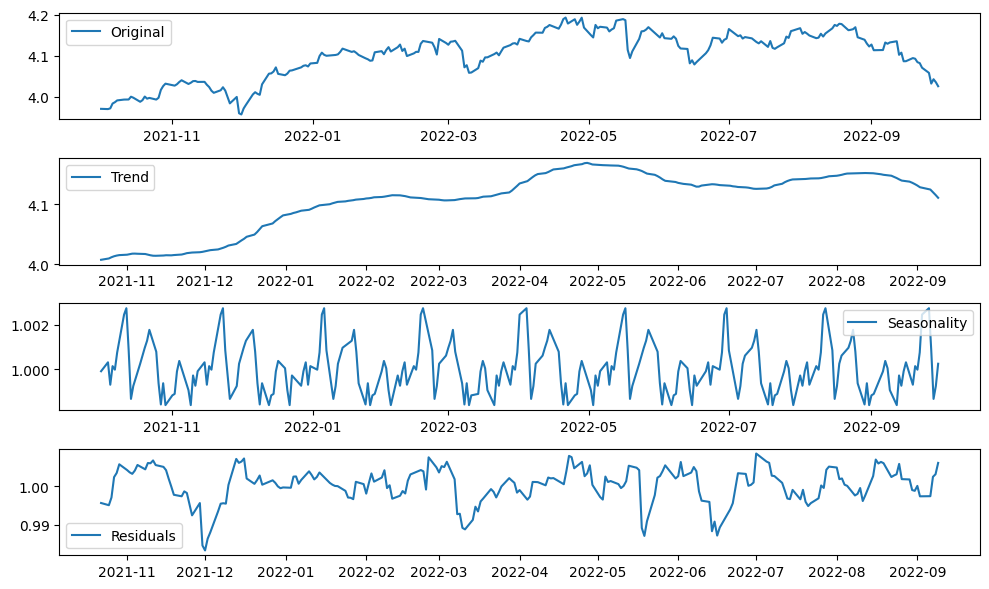

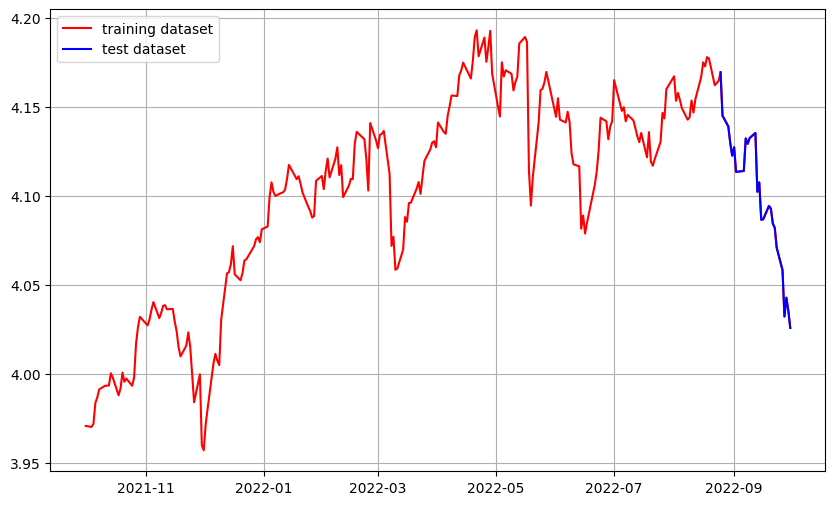

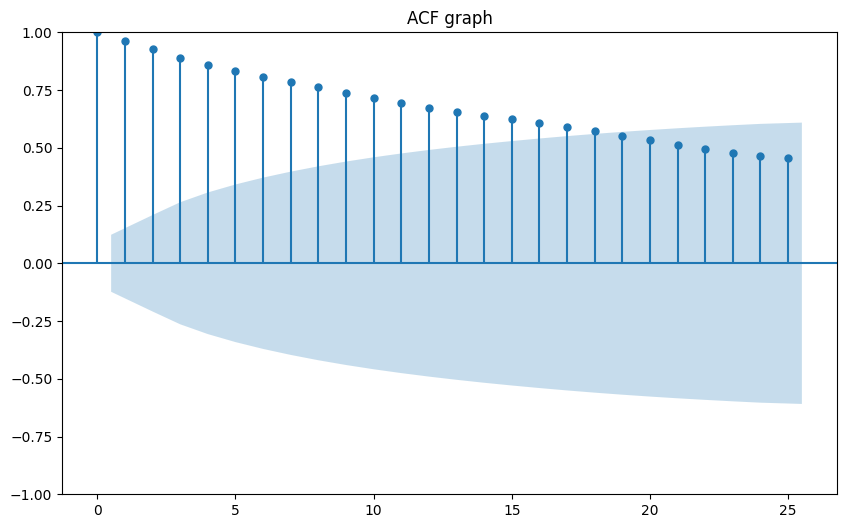

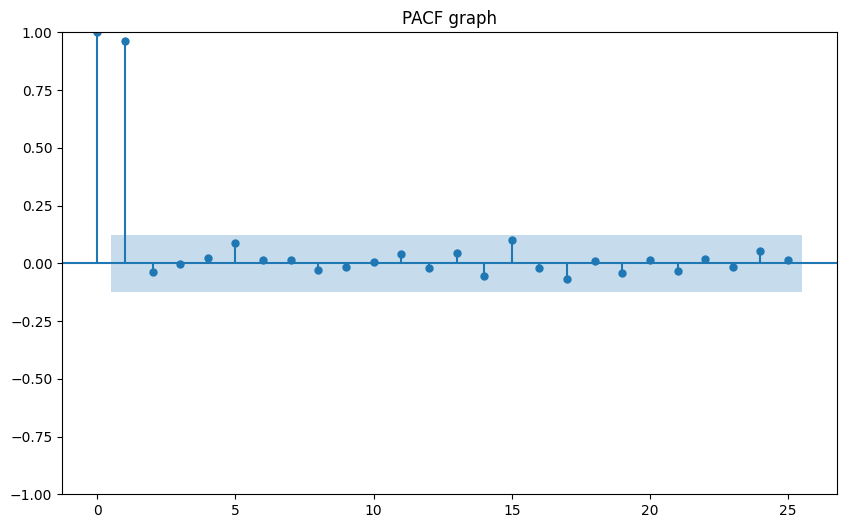

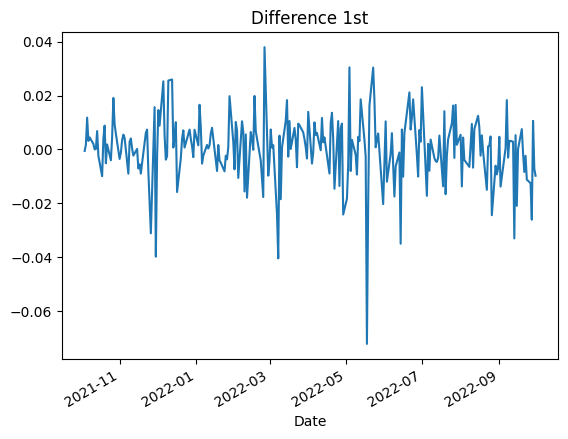

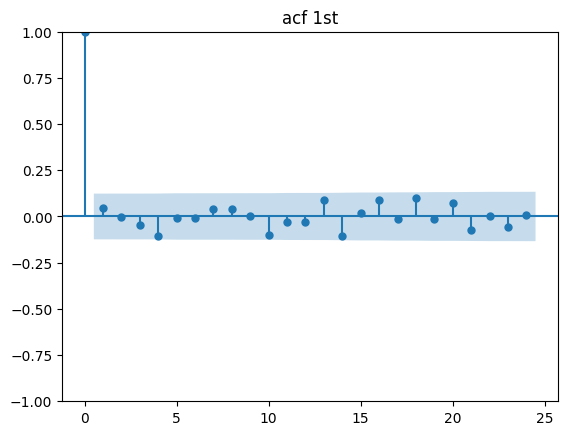

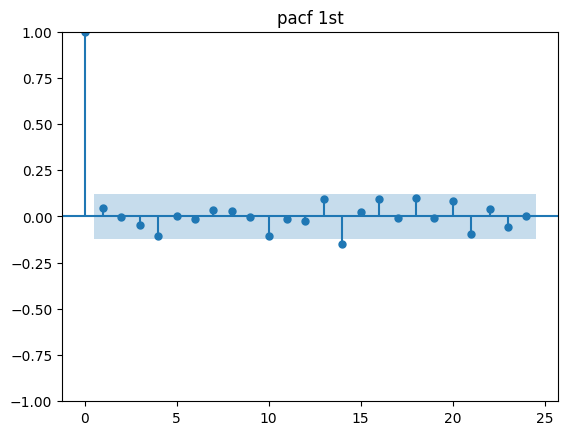

Test Statistic : -14.984412890174386
p-value : 1.1494734669617716e-27
#Lags Used : 0
Number of Observations Used : 250
Critical Value (1%) : -3.456780859712
Critical Value (5%) : -2.8731715065600003
Critical Value (10%) : -2.572968544
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 672.151
Date:                Sat, 01 Oct 2022   AIC                          -1340.302
Time:                        18:44:27   BIC                          -1333.470
Sample:                             0   HQIC                         -1337.544
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

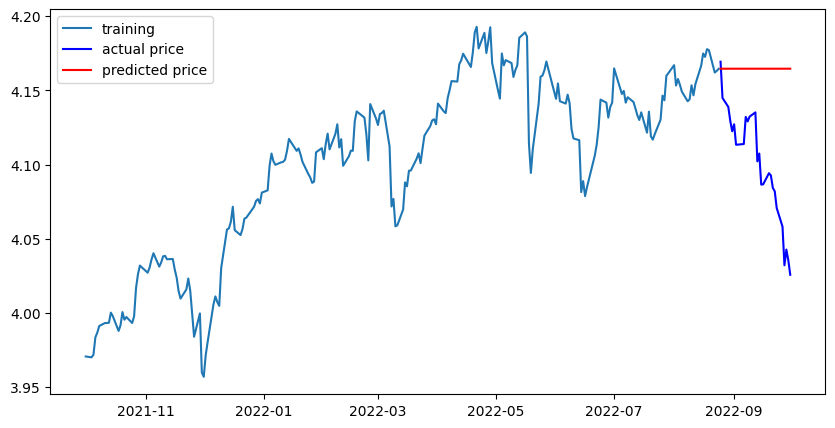

MSE:  21.07491100593385
MAE:  4.033304888848215
RMSE:  4.590741879689365
MAPE: 6.83%

############# caca cola analysis end #############


############# starbucks analysis #############



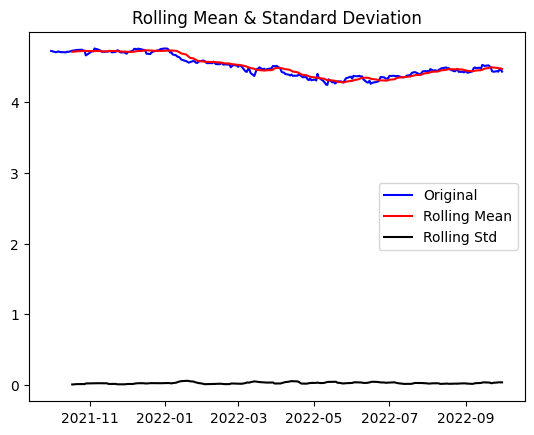


after log trans
stationary한 시계열 데이터가 아닙니다.
Test Statistic : -1.4985225654937038
p-value : 0.5342420776167909
#Lags Used : 0
Number of Observations Used : 251
Critical Value (1%) : -3.4566744514553016
Critical Value (5%) : -2.8731248767783426
Critical Value (10%) : -2.5729436702592023

after except seasonal, transe
Test Statistic : -6.078474983785481
p-value : 1.1068122713145018e-07
#Lags Used : 11
Number of Observations Used : 210
Critical Value (1%) : -3.461878735881654
Critical Value (5%) : -2.875403665910809
Critical Value (10%) : -2.574159410430839


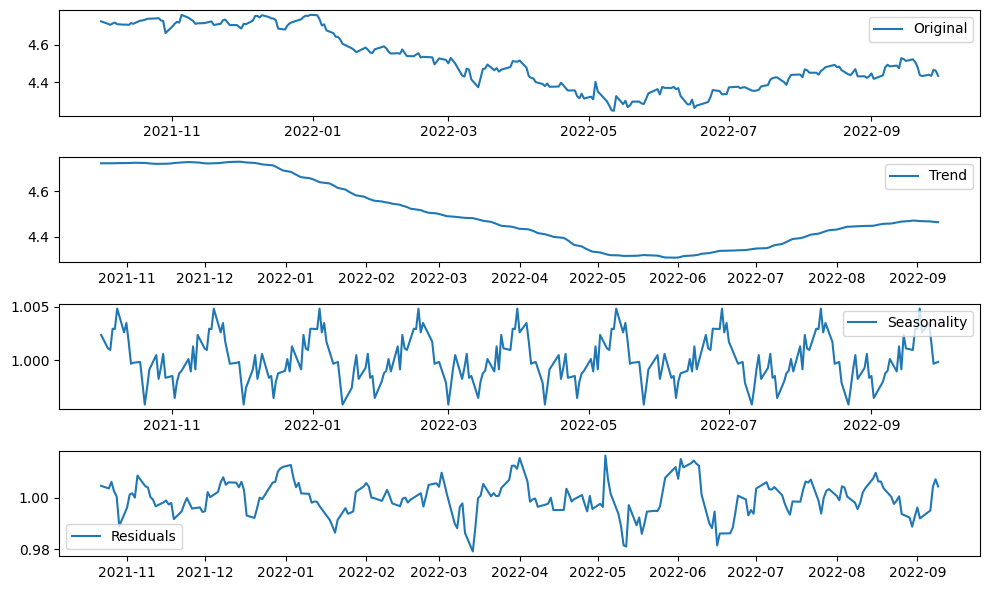

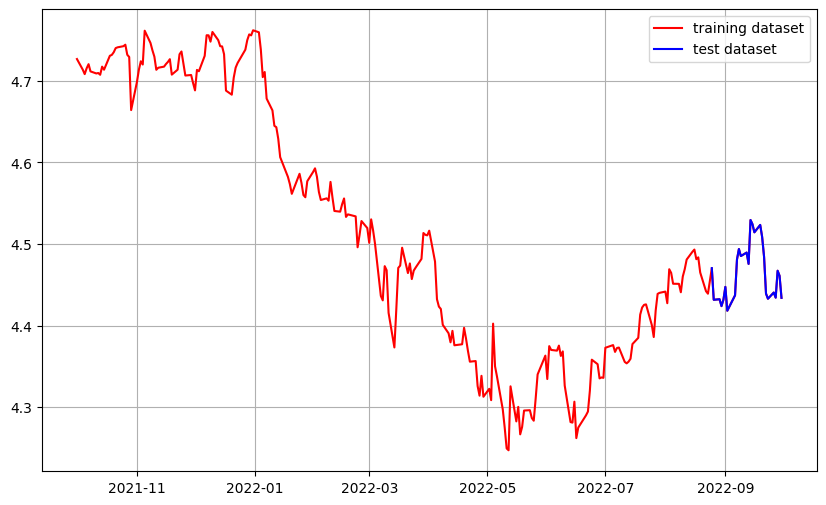

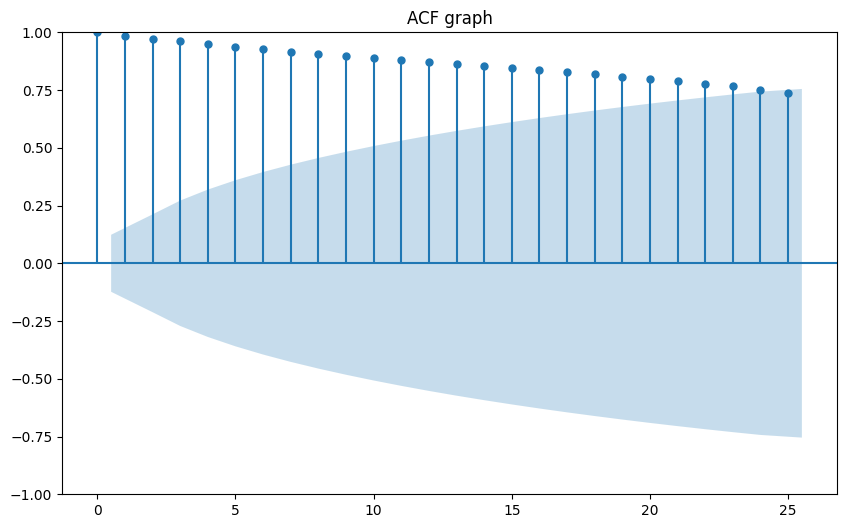

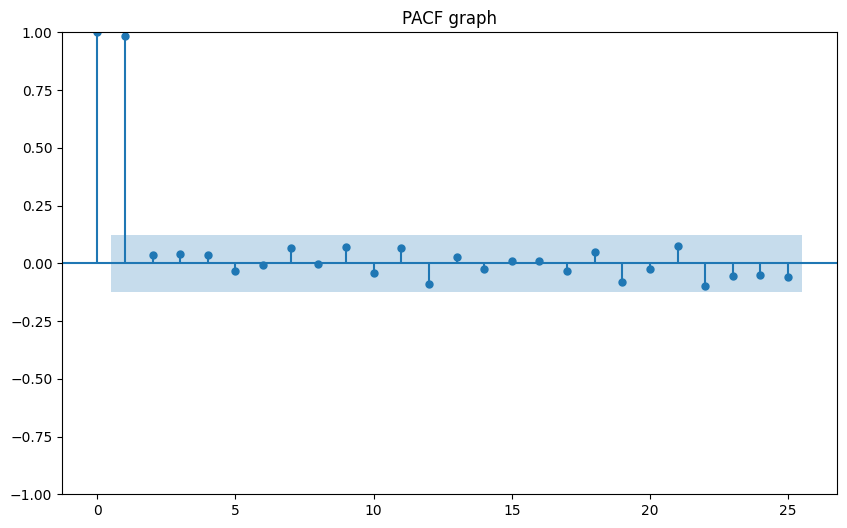

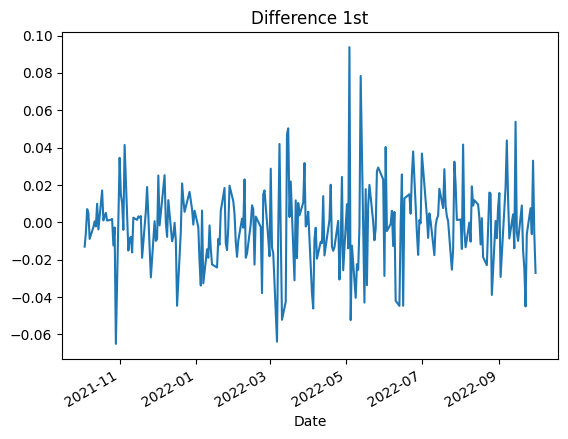

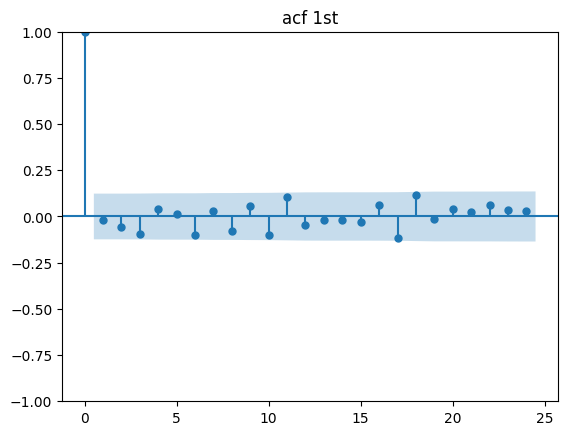

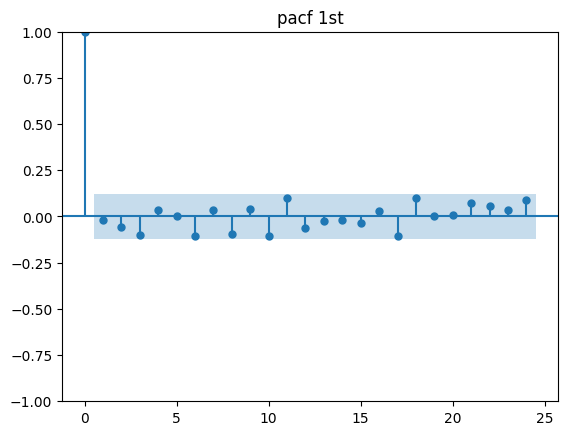

Test Statistic : -16.02705877451442
p-value : 6.114970951202653e-29
#Lags Used : 0
Number of Observations Used : 250
Critical Value (1%) : -3.456780859712
Critical Value (5%) : -2.8731715065600003
Critical Value (10%) : -2.572968544
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 545.550
Date:                Sat, 01 Oct 2022   AIC                          -1087.099
Time:                        18:44:29   BIC                          -1080.267
Sample:                             0   HQIC                         -1084.342
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

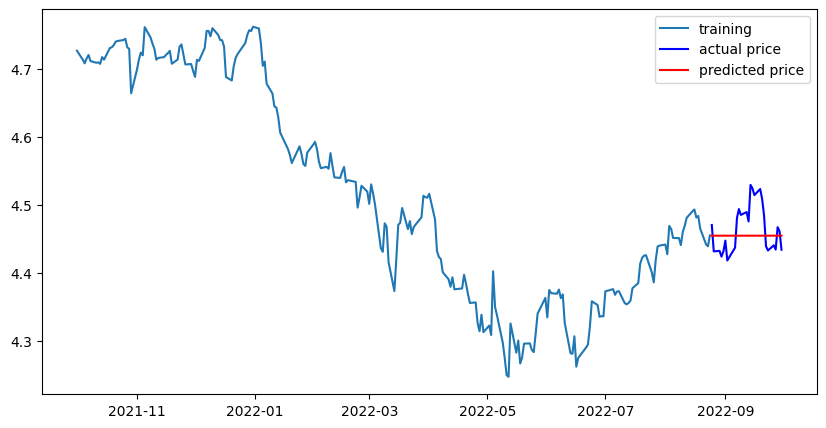

MSE:  10.033507481342717
MAE:  2.6697717199664357
RMSE:  3.1675712275089754
MAPE: 3.02%

############# starbucks analysis end #############


############# nike analysis #############



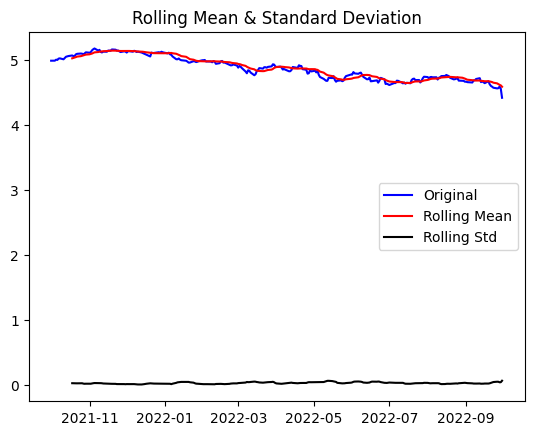


after log trans
stationary한 시계열 데이터가 아닙니다.
Test Statistic : 0.36566582873668685
p-value : 0.9801645525043281
#Lags Used : 0
Number of Observations Used : 251
Critical Value (1%) : -3.4566744514553016
Critical Value (5%) : -2.8731248767783426
Critical Value (10%) : -2.5729436702592023

after except seasonal, transe
Test Statistic : -6.089103812121733
p-value : 1.0469081938022155e-07
#Lags Used : 11
Number of Observations Used : 210
Critical Value (1%) : -3.461878735881654
Critical Value (5%) : -2.875403665910809
Critical Value (10%) : -2.574159410430839


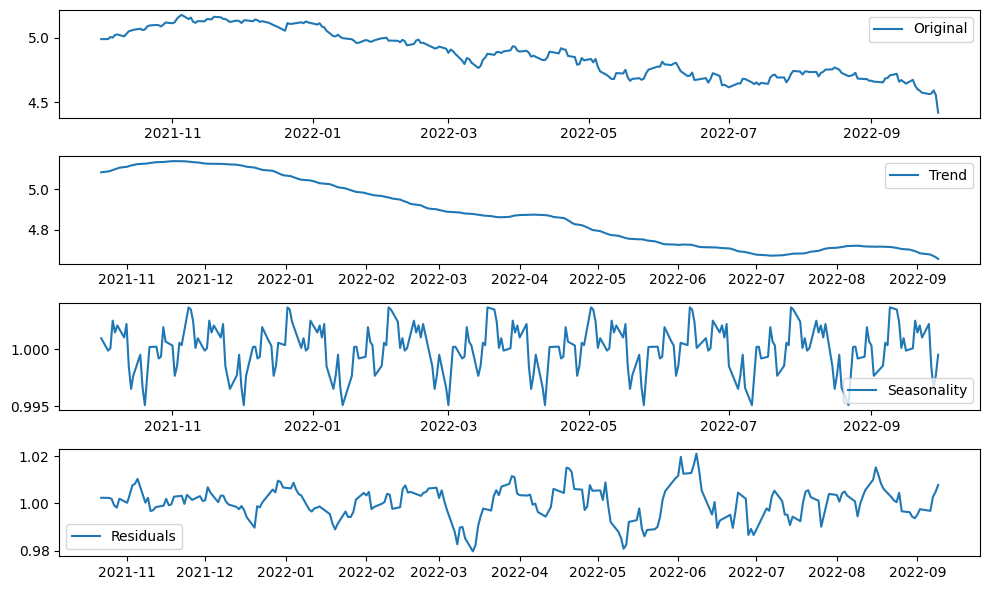

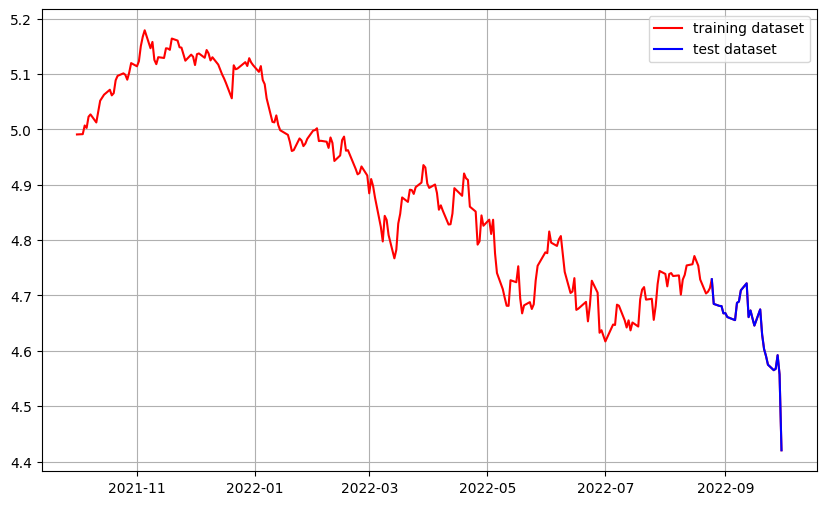

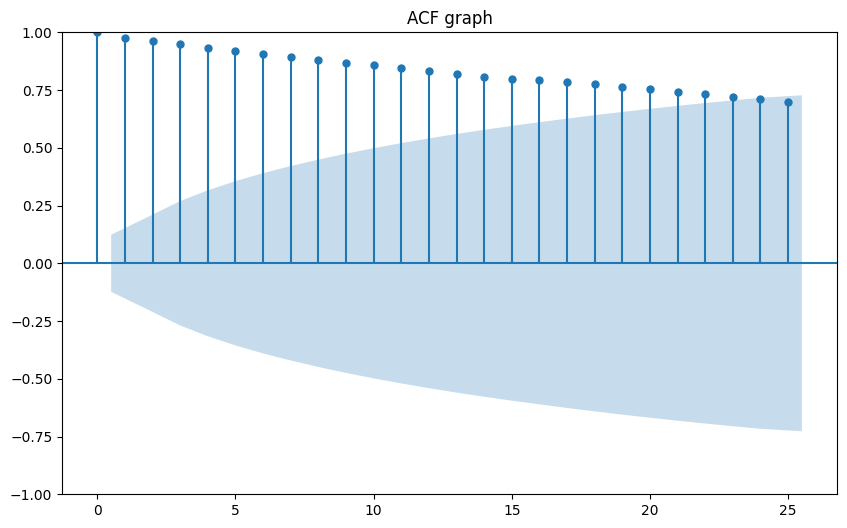

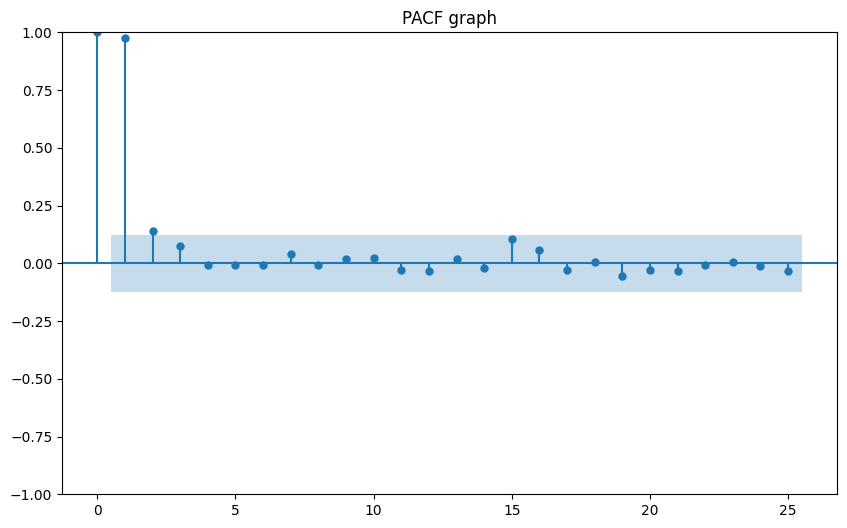

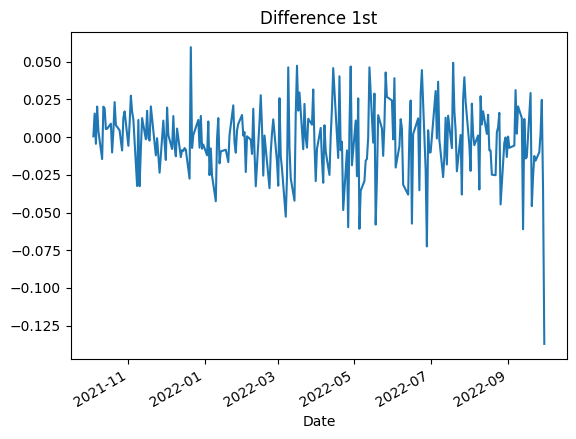

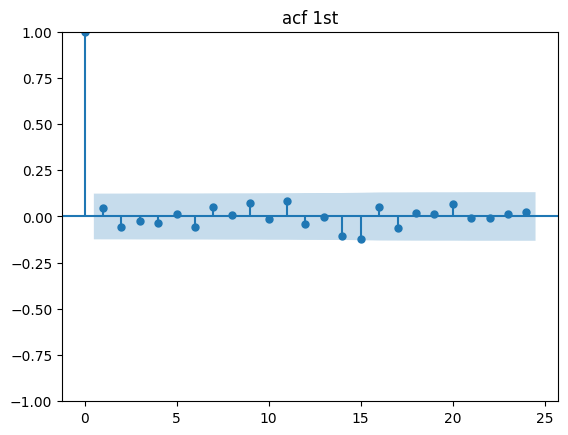

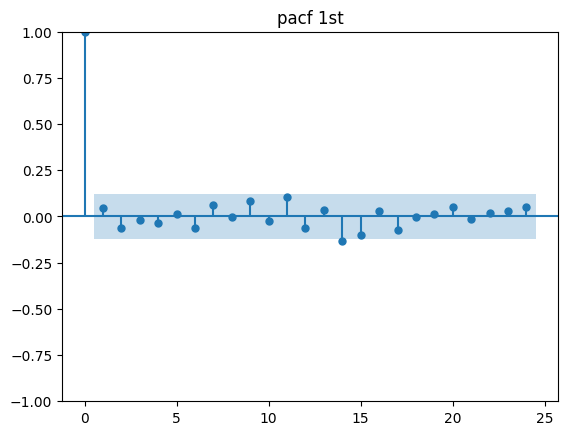

Test Statistic : -13.97822281070166
p-value : 4.223638472176531e-26
#Lags Used : 0
Number of Observations Used : 250
Critical Value (1%) : -3.456780859712
Critical Value (5%) : -2.8731715065600003
Critical Value (10%) : -2.572968544
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 536.633
Date:                Sat, 01 Oct 2022   AIC                          -1069.266
Time:                        18:44:30   BIC                          -1062.434
Sample:                             0   HQIC                         -1066.508
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

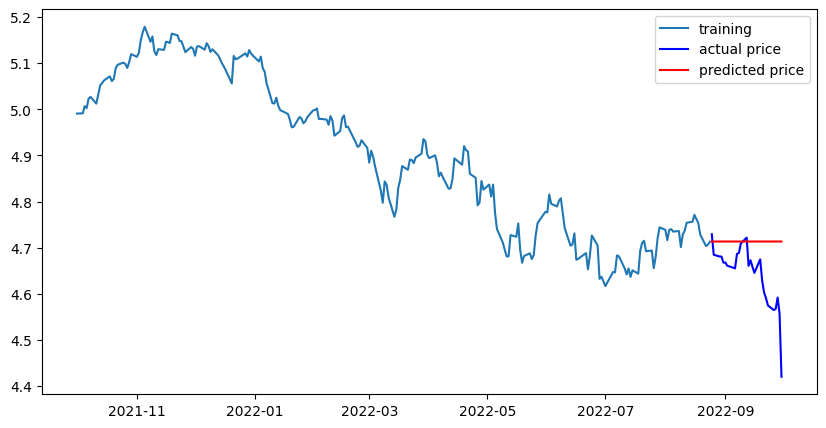

MSE:  100.74556847394818
MAE:  7.866142914786461
RMSE:  10.037209197478559
MAPE: 8.02%

############# nike analysis end #############


############# amazon analysis #############



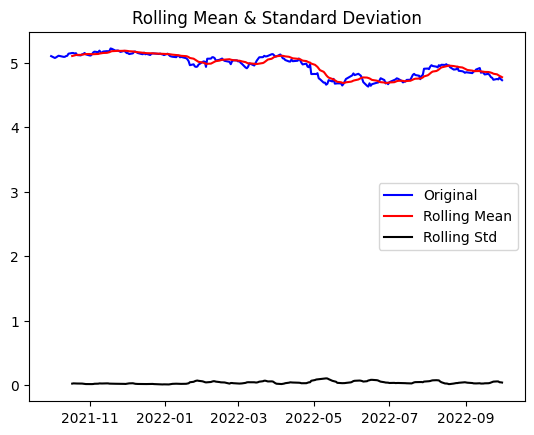


after log trans
stationary한 시계열 데이터가 아닙니다.
Test Statistic : -1.1488735006947868
p-value : 0.6951936877984
#Lags Used : 0
Number of Observations Used : 251
Critical Value (1%) : -3.4566744514553016
Critical Value (5%) : -2.8731248767783426
Critical Value (10%) : -2.5729436702592023

after except seasonal, transe
Test Statistic : -5.210608887411345
p-value : 8.364040131136026e-06
#Lags Used : 2
Number of Observations Used : 219
Critical Value (1%) : -3.460567372610299
Critical Value (5%) : -2.874829809033386
Critical Value (10%) : -2.573853225954421


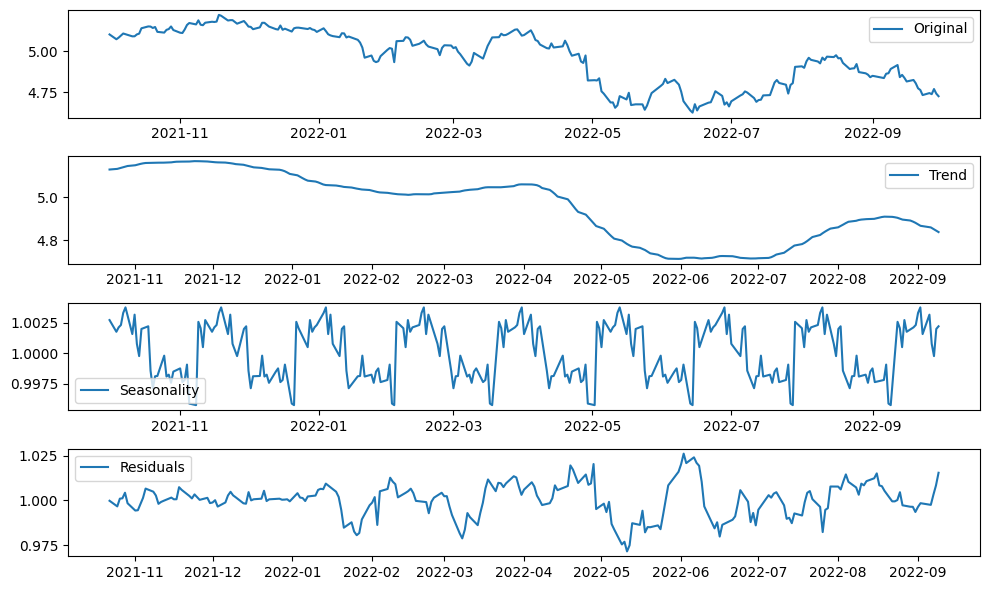

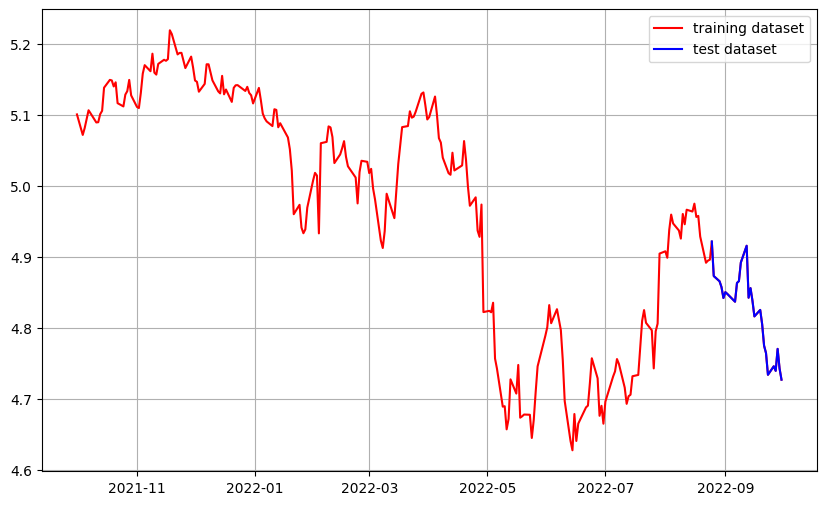

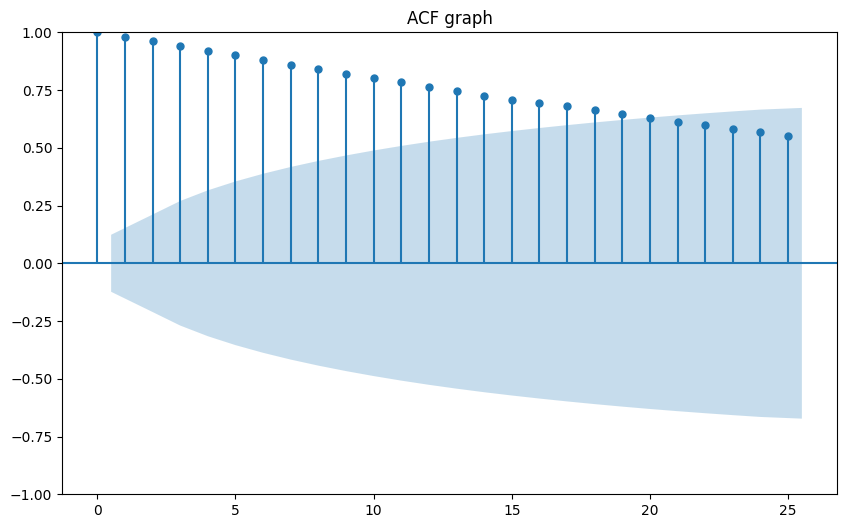

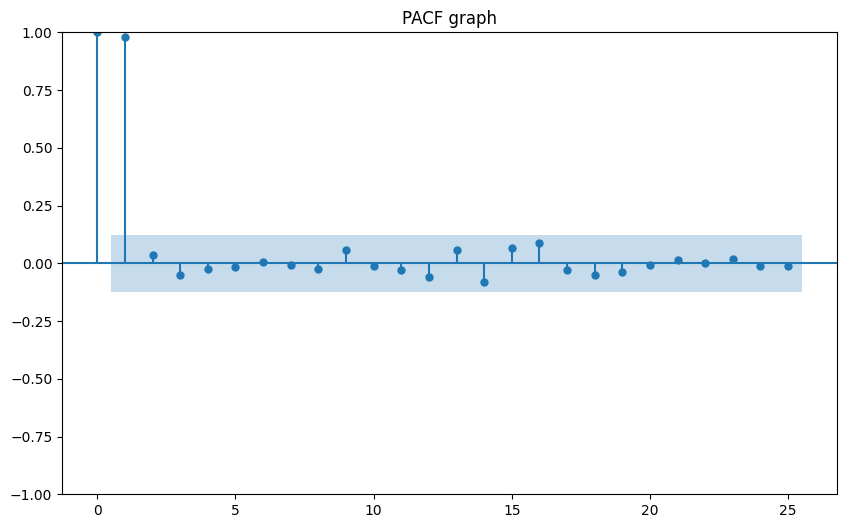

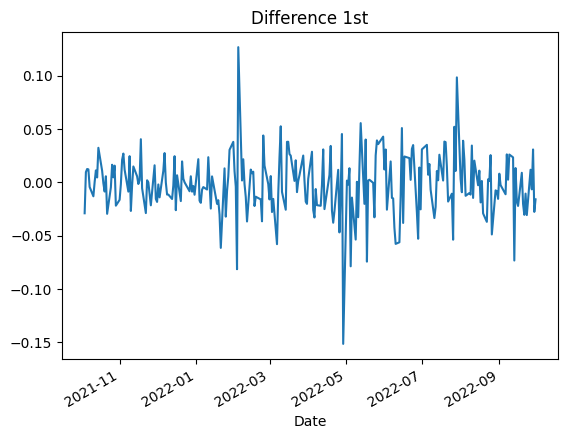

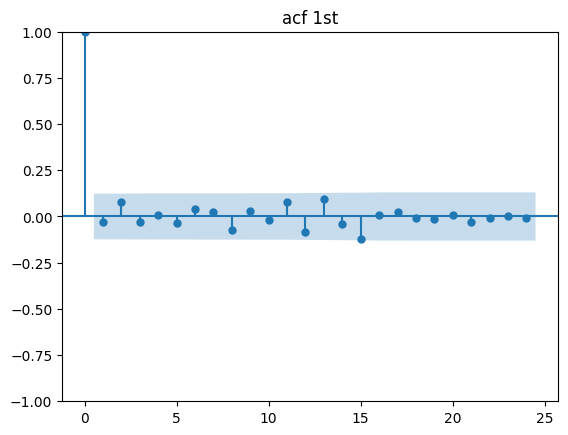

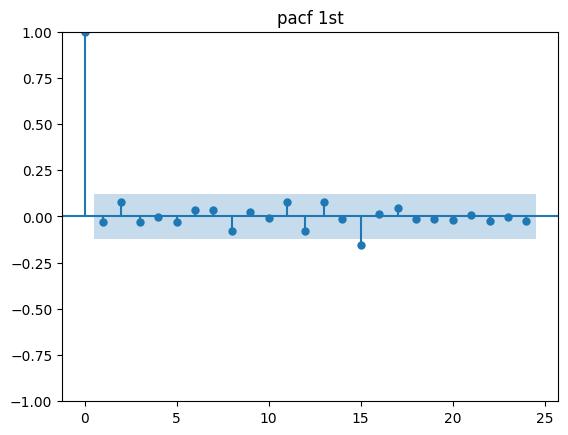

Test Statistic : -16.239970541961224
p-value : 3.7361693142061057e-29
#Lags Used : 0
Number of Observations Used : 250
Critical Value (1%) : -3.456780859712
Critical Value (5%) : -2.8731715065600003
Critical Value (10%) : -2.572968544
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 476.787
Date:                Sat, 01 Oct 2022   AIC                           -949.573
Time:                        18:44:32   BIC                           -942.741
Sample:                             0   HQIC                          -946.816
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

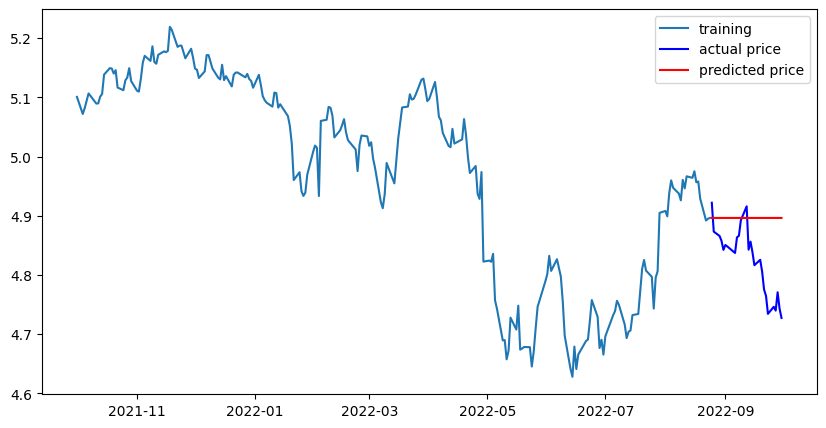

MSE:  131.4143227895887
MAE:  9.623048877204834
RMSE:  11.463608628594606
MAPE: 8.02%

############# amazon analysis end #############


############# oracle analysis #############



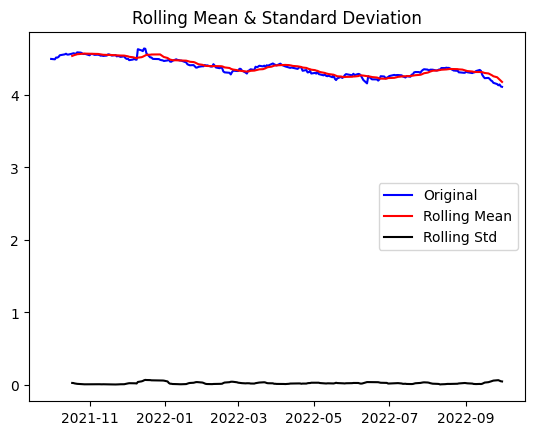


after log trans
stationary한 시계열 데이터가 아닙니다.
Test Statistic : -0.6238985427129732
p-value : 0.865489985278401
#Lags Used : 0
Number of Observations Used : 251
Critical Value (1%) : -3.4566744514553016
Critical Value (5%) : -2.8731248767783426
Critical Value (10%) : -2.5729436702592023

after except seasonal, transe
Test Statistic : -6.411454551544142
p-value : 1.8863521670478752e-08
#Lags Used : 4
Number of Observations Used : 217
Critical Value (1%) : -3.460849270544952
Critical Value (5%) : -2.87495318813585
Critical Value (10%) : -2.5739190539191745


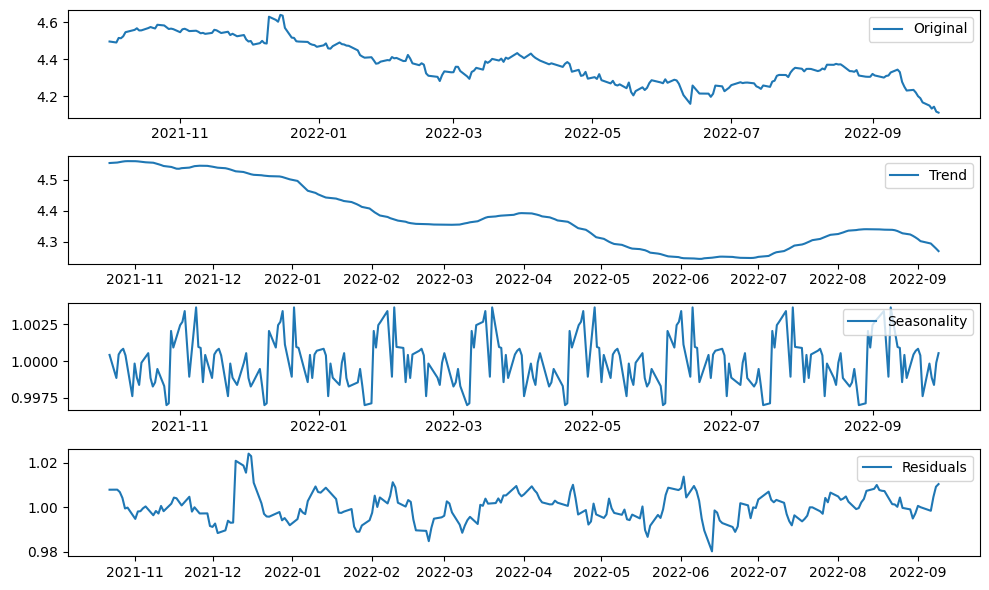

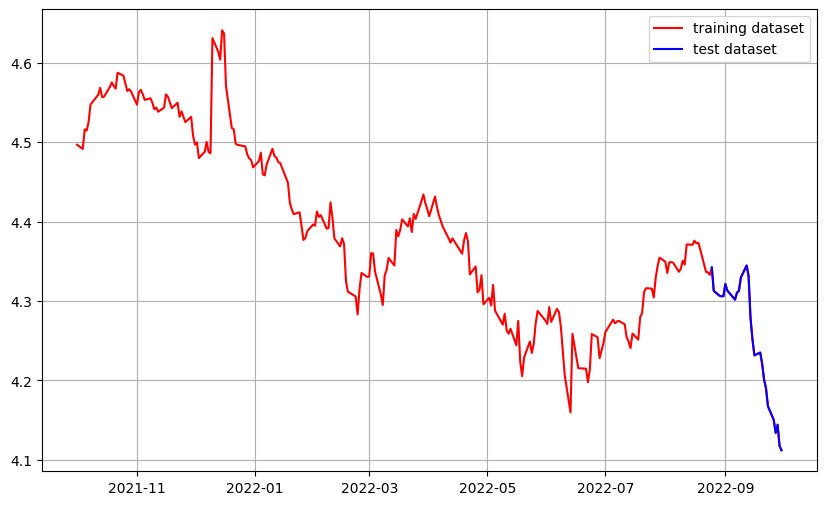

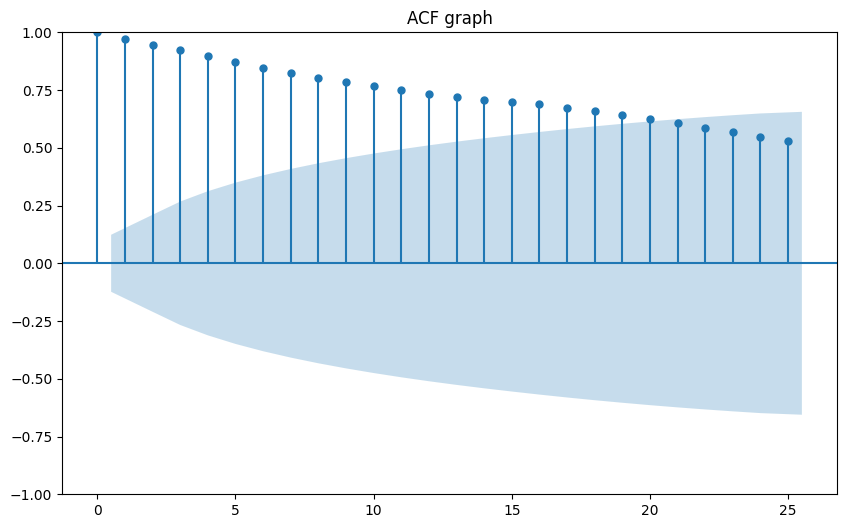

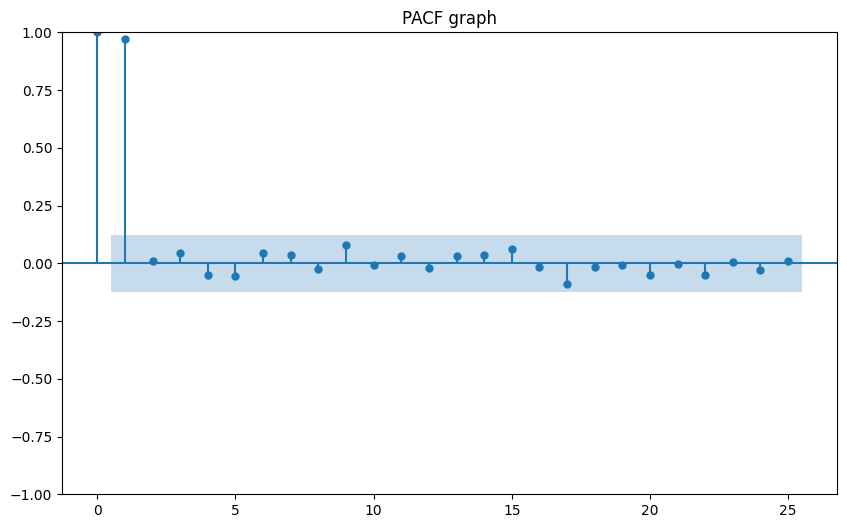

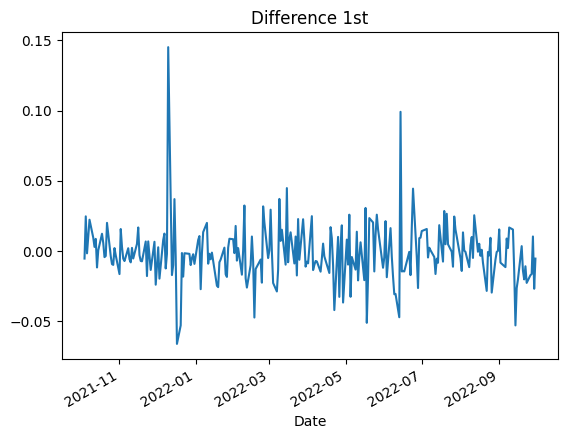

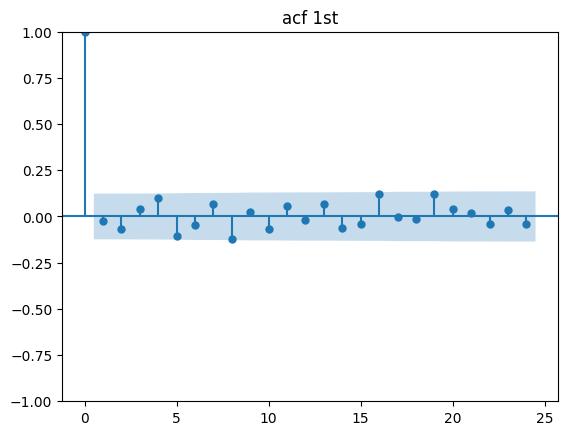

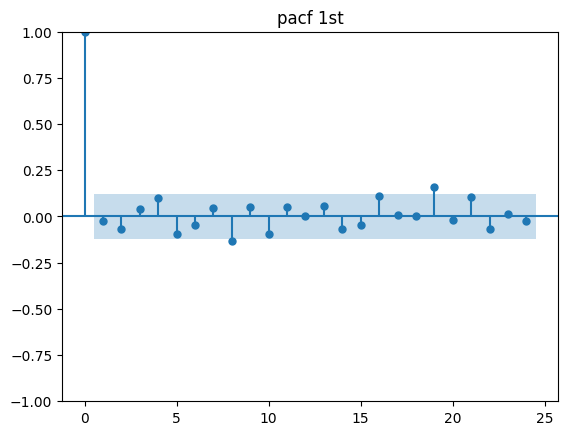

Test Statistic : -16.15181809154733
p-value : 4.561072166845402e-29
#Lags Used : 0
Number of Observations Used : 250
Critical Value (1%) : -3.456780859712
Critical Value (5%) : -2.8731715065600003
Critical Value (10%) : -2.572968544
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 552.573
Date:                Sat, 01 Oct 2022   AIC                          -1101.146
Time:                        18:44:34   BIC                          -1094.314
Sample:                             0   HQIC                         -1098.388
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

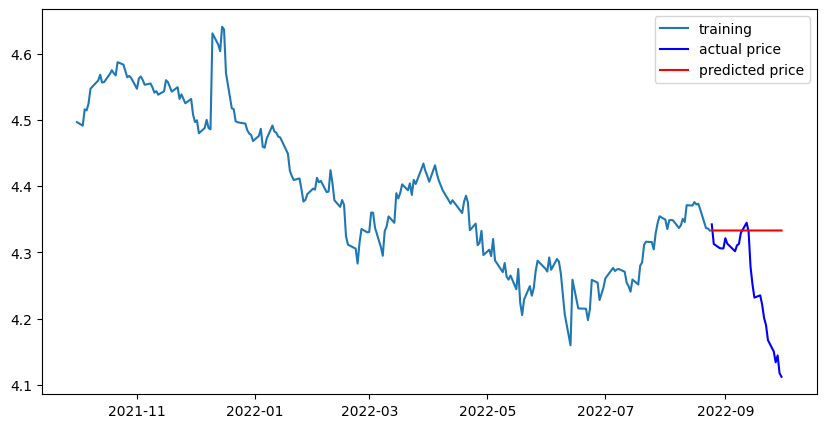

MSE:  59.589240861790344
MAE:  5.80214514739254
RMSE:  7.719406768773773
MAPE: 8.84%

############# oracle analysis end #############

comapny predict MAPE list
caca cola :6.83 %
starbucks :3.02 %
nike :8.02 %
amazon :8.02 %
oracle :8.84 %


In [15]:
MAPE_list = {} # 기업별 MAPE

for csv_name, com in COM_DICT.items():
    print(f"\n############# {com} analysis #############\n")

    MAPE_list[com] = analysis(csv_name)

    print(f"\n############# {com} analysis end #############\n")

print(f"comapny predict MAPE list")
for com, mape in MAPE_list.items():
    print(f"{com} :{mape} %")

## 회고

이 과제는 주식에 관한 용어 또는 통계에 관련된 지식의 벽으로 인해 많이 힘들었던 과제로 생각된다.</br>
특히 `ARIMA` `p`,`d`,`q`파라미터는 아직도 아래의 실험으로 인하여 의문점이 남는다.
- 예제플로에서 `p`,`d`,`q`을 각각 공식을 통해 `1, 1, 0` 로 구했지만</br>
   `2, 0, 1`가 실제로는 가장 낮은값이 나왔다.
- 자동으로 `p`,`d`,`q`를 구할 시 경고 메세지가 출력되며 이게 계산의 어떤부분에 영향을 미치는지 알 수없다.</br>